In [1]:
import txt_binary as tb
import BinaryToCodeword as b2c
import CodewordToBinary as c2b

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# Codewords

In [2]:
def textToCodewords(txt):
    bits = tb.text_to_bits(txt)
    codeword = b2c.f(bits)
    return codeword


def codewordToText(codeword):
    bits2 = c2b.f(codeword)
    res = tb.text_from_bits(bits2)
    return res

# Clap

In [3]:
#clap = np.random.choice([-1,1], 133)
#np.savetxt("clap_end.txt", clap)

# $\psi$(t) : a root-raised-cosine

In [4]:
beta = 1/2.0

#T_psi : good values begin at 1/400
T_psi = 1/600.0 # we want it small
print("The frequency-band will have a width of:",1/T_psi,"Hz until 1/2T (see p. 171)")

def psi(t):
    c = 1.0 - np.square(4.0 * beta * t / T_psi)
    
    temp_error = np.geterr()
    np.seterr(divide='ignore', invalid='ignore')
    res = np.where(np.abs(c) <= 1E-2,
                   (beta / (np.pi * np.sqrt(2 * T_psi)))
                   * ((np.pi + 2) * np.sin(np.pi / (4 * beta))
                      +(np.pi - 2) * np.cos(np.pi / (4 * beta))),
                   
                   (4.0 * beta)/(np.pi * np.sqrt(T_psi))
                   * (np.cos((1.0 + beta) * np.pi * t / T_psi)
                      + ((1.0 - beta) * np.pi) / (4.0 * beta) * np.sinc((1.0 - beta) * t / T_psi))
                   / c
                   )
    np.seterr(divide='warn', invalid='warn')
    
    return res

The frequency-band will have a width of: 600.0 Hz until 1/2T (see p. 171)


# Init some variables

In [5]:
ff = 2000 # frequency of the signal in Hz
Fs = 22050 # given
Ts = 1.0/Fs # sampling interval
time_interval = 0.003
t = np.arange(-time_interval, time_interval, Ts) # time vector

# Modulate $\psi$(t) to get a signal base

In [6]:
# Modulate a given signal to 2000Hz, 4000Hz, 6000Hz and 8000Hz and resize it to [-1,1]
def modulate_and_resize(signal):
    y = signal * np.cos(2*np.pi*ff*t) + signal * np.cos(2*2*np.pi*ff*t) + signal * np.cos(3*2*np.pi*ff*t) + signal * np.cos(4*2*np.pi*ff*t)
    ymax = np.max(np.abs(y))
    y /= ymax
    return y

def getSignal():
    y = modulate_and_resize(psi(t))
    return y

# base represents the base wave modulated at 4 different frequencies
base = modulate_and_resize(psi(t))
base_len = len(base)

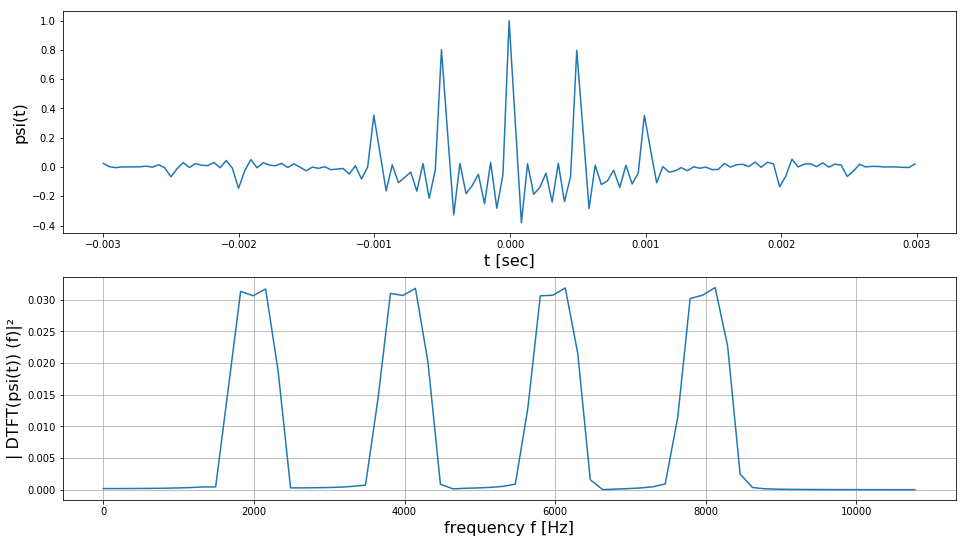

In [7]:
################
##### PLOT #####
################
n = len(base)
k = np.arange(n)
T = n/Fs
frq = k/T # two sides frequency range
frq = frq[range(n // 2)] # one side frequency range (7 = 3*2+1 ==> 7//2 = 6//2 = 3)

Y = np.fft.fft(base)/n # fft computing and normalization
Y = Y[range(n // 2)]

plt.figure(figsize=(16,9))
plt.subplot(211)
plt.plot(t,base)
plt.xlabel("t [sec]",fontsize=16)
plt.ylabel("psi(t)",fontsize=16)
plt.subplot(212)
plt.plot(frq, np.abs(Y))
plt.xlabel("frequency f [Hz]",fontsize=16)
plt.ylabel("| DTFT(psi(t)) (f)|²",fontsize=16)
plt.grid()
plt.show()

# Encoding

In [8]:
def encode(list_codewords, base):
    base_length = len(base)
    signal = np.zeros(len(list_codewords) * base_length)
    
    for i in range(len(list_codewords)):
        for j in range(base_length):
            signal[i * base_length + j] = list_codewords[i] * base[j]
    
    # Add start clap
    signal_with_clap_start = []
    for i in range(len(signal) + len(clap_start)):
        if(i < len(clap_start)):
            signal_with_clap_start.append(clap_start[i])
        else:
            signal_with_clap_start.append(signal[i-len(clap_start)])
            
    # Add clap end
    signal_with_clap_start_end = []
    for i in range(len(signal_with_clap_start) + len(clap_end)):
        if(i < len(signal_with_clap_start)):
            signal_with_clap_start_end.append(signal_with_clap_start[i])
        else:
            signal_with_clap_start_end.append(clap_end[i-len(signal_with_clap_start)])
    
    
    return signal_with_clap_start_end

In [9]:
#Reload clap
clap_start = np.loadtxt("clap_start.txt")
clap_end = np.loadtxt("clap_end.txt")
clap_len = len(clap_start)

In [10]:
code = b2c.f(tb.text_to_bits('c')) #5*'abcdefghijklmnopqrstuvwxyz0123456789'
signal = encode(code, base)

In [11]:
#np.savetxt("to_send_very_long_end.txt", signal)

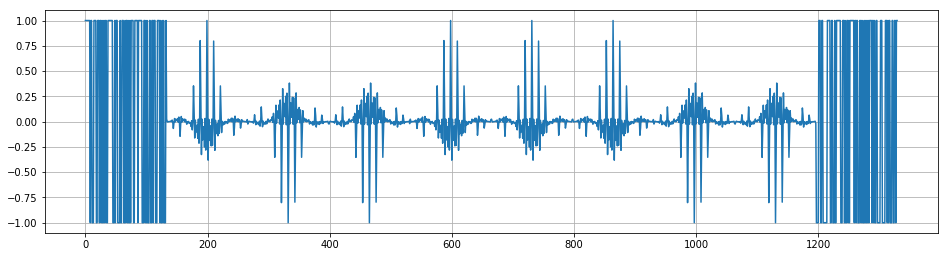

In [12]:
################
##### PLOT #####
################
plt.figure(figsize=(16,9))
plt.subplot(211)
plt.plot(signal)
plt.grid()

# Parameter estimation

In [13]:
def findOffset(signal_received, signal_desired):
    signal_desired_length = len(signal_desired)
    
    a = []
    for i in range(len(signal_received) - signal_desired_length):
        temp = 0
        for j in range(signal_desired_length):
            temp += signal_received[i+j] * signal_desired[j]
        a.append(temp)

    ################
    ##### PLOT #####
    ################
    #Je le plot pour essayer de voir si y a pas un moyen de réduire le nombre de calcul
    plt.figure(figsize=(16,9))
    plt.subplot(211)
    plt.plot(a)
    plt.grid()    
    
    return np.argmax(np.abs(a))

def offsets(rcv_signal):
    clap_start = np.loadtxt("clap_start.txt")
    clap_end = np.loadtxt("clap_end.txt")
    
    start = findOffset(rcv_signal, clap_start)
    end = findOffset(rcv_signal, clap_end)
    
    #verify multiple of 8 * 133 (8 bits * len(base)), else take more/less values at the end
    if(end-start > 0 and (end-start) % 8 != 0):
        temp = end-start // base_len
        if (temp % 8 < 4):
            end = start + ((end - start) // (base_len*8)) * base_len * 8
        else:
            end = start + (((end - start) // (base_len*8)) + 1) * base_len * 8
    
    res = [start,end]
    
    return res

# Decode

In [14]:
received = np.loadtxt("received_very_long_end.txt")

In [15]:
import time
def decode(rcv_signal, base):
    base_len = len(base)
    
    now = time.time()
    
    tab_offsets = offsets(rcv_signal)
    
    after = time.time()
    print("time to compute parameters :",after-now)
    
    offset_start = tab_offsets[0] + clap_len
    offset_end = tab_offsets[1]

    decoded = []
    for i in range(offset_start, offset_end + 1, base_len):
        temp = 0
        for j in range(base_len):
            temp += rcv_signal[i + j] * base[j]
        decoded.append(temp)
        
    return decoded

time to compute parameters : 13.62572455406189


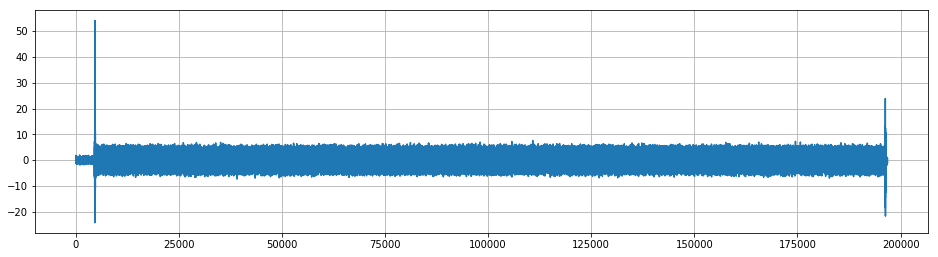

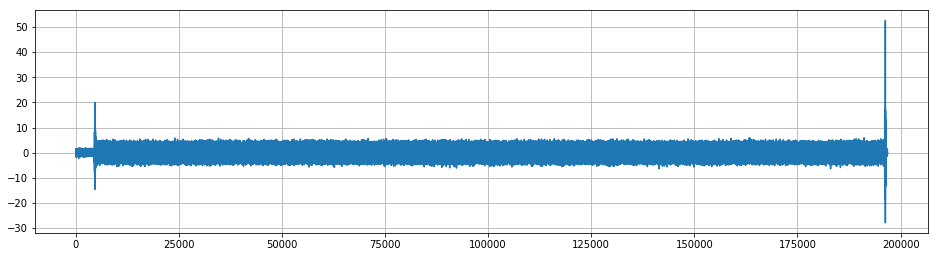

In [16]:
decoded = decode(received, base)

In [17]:
#Decision rule
for i in range(len(decoded)):
    if (decoded[i] > 0):
        decoded[i] = 1
    else:
        decoded[i] = -1

temp = len(decoded) // 8
final_res = codewordToText(decoded[:temp*8])
print(final_res)
print("length :",len(final_res))

abcdefghijklmnopqrstuvwxyz0123456789abcdefghijklmnopqrstuvwxyz0123456789abcdefghijklmnopqrstuvwxyz0123456789abcdefghijklmnopqrstuvwxyz0123456789abcdefghijklmnopqrstuvwxyz0123456789
length : 180
